In [ ]:
!unzip "/content/drive/MyDrive/LayoutLMv2/dataset/CORD.zip" -d '/content/dataset'/

Archive:  /content/drive/MyDrive/LayoutLMv2/dataset/CORD.zip
   creating: /content/dataset/CORD/
   creating: /content/dataset/CORD/dev/
   creating: /content/dataset/CORD/dev/image/
  inflating: /content/dataset/CORD/dev/image/receipt_00074.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00099.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00073.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00063.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00005.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00049.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00075.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00070.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00067.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00077.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00010.png  
  inflating: /content/dataset/CORD/dev/image/receipt_00071.png  
  inflating: /content/dataset/CORD/de

# Analysis

In [ ]:
from PIL import Image

image = Image.open('/content/dataset/CORD/train/image/receipt_00000.png')
image

In [ ]:
import json

with open('/content/dataset/CORD/train/json/receipt_00000.json', 'r') as json_file:
    data = json.load(json_file)

In [ ]:
data.keys()

In [ ]:
data['meta']

In [ ]:
data['roi']

In [ ]:
data['repeating_symbol']

In [ ]:
len(data['valid_line'])

In [ ]:
data['valid_line'][0]

In [ ]:
import random

labels = ['menu.cnt',
 'menu.discountprice',
 'menu.etc',
 'menu.itemsubtotal',
 'menu.nm',
 'menu.num',
 'menu.price',
 'menu.sub_cnt',
 'menu.sub_etc',
 'menu.sub_nm',
 'menu.sub_price',
 'menu.sub_unitprice',
 'menu.unitprice',
 'menu.vatyn',
 'sub_total.discount_price',
 'sub_total.etc',
 'sub_total.othersvc_price',
 'sub_total.service_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'total.cashprice',
 'total.changeprice',
 'total.creditcardprice',
 'total.emoneyprice',
 'total.menuqty_cnt',
 'total.menutype_cnt',
 'total.total_etc',
 'total.total_price',
 'void_menu.nm',
 'void_menu.price']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

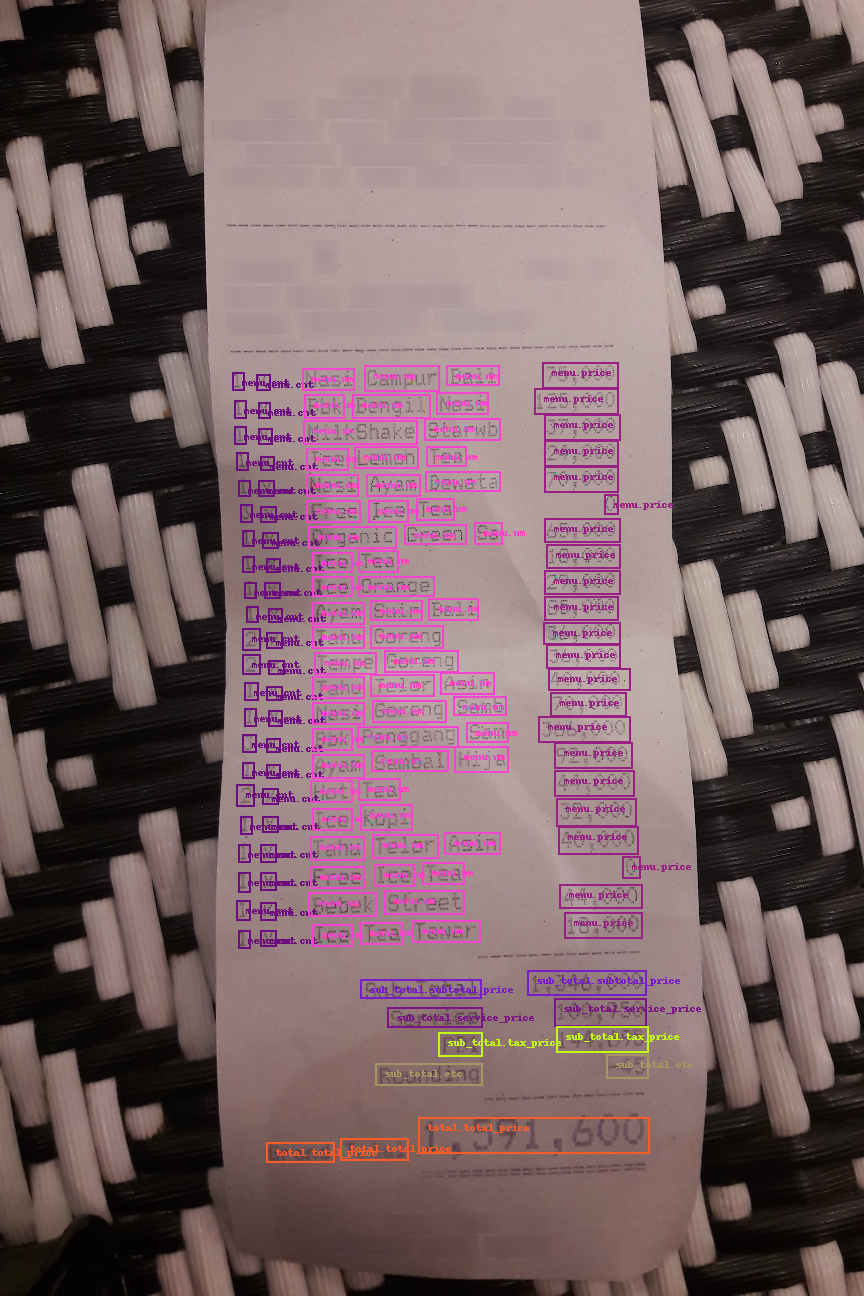

In [ ]:
from PIL import ImageDraw, ImageFont

image = Image.open('/content/dataset/CORD/train/image/receipt_00000.png')
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
    label = annotation['category']
    words = annotation['words']
    for word in words:
        coordinates = word['quad']
        x1, y1 = coordinates['x1'], coordinates['y1']
        x3, y3 = coordinates['x3'], coordinates['y3']
        box = [x1, y1, x3, y3]
        draw.rectangle(box, outline=label2color[label], width=2)
        draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)
        # break

image

# Generating the dataset

In [ ]:
import os
from tqdm.notebook import tqdm

def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height))
    ]

def generate_annotations(path: str):
    annotation_files = []
    file_names = []
    for js in tqdm(os.listdir(path)):
        with open(path+js) as f:
            annotation_files.append(json.load(f))
        file_names.append(js)
    
    words = []
    boxes = []
    labels = []
    for js in tqdm(annotation_files):
        words_example = []
        boxes_example = []
        labels_example = []
        file_names_example = []

        width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']

        # loop over OCR annotations
        for elem in js['valid_line']:
            for word in elem['words']:
                txt = word['text']
                x1 = word['quad']['x1']
                y1 = word['quad']['y1']
                x3 = word['quad']['x3']
                y3 = word['quad']['y3']

                box = [x1, y1, x3, y3]
                box = normalize_bbox(box, width=width, height=height)

                # skip empty word
                if len(txt) < 1:
                    continue
                if min(box) < 0 or max(box) > 1000:
                    continue
                if ((box[3] - box[1]) < 0 or (box[2] - box[0]) < 0):
                    continue
                
                words_example.append(txt)
                boxes_example.append(box)
                labels_example.append(elem['category'])
        words.append(words_example)
        boxes.append(boxes_example)
        labels.append(labels_example)
    
    return words, boxes, labels, file_names

In [ ]:
train_path = '/content/dataset/CORD/train/json/'
val_path = '/content/dataset/CORD/dev/json/'
test_path = '/content/dataset/CORD/test/json/'

words_train, boxes_train, labels_train, file_names_train = generate_annotations(train_path)
words_val, boxes_val, labels_val, file_names_val = generate_annotations(val_path)
words_test, boxes_test, labels_test, file_names_test = generate_annotations(test_path)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
file_names_train[0]

'receipt_00158.json'

In [ ]:
labels_train[0]

['menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'sub_total.subtotal_price',
 'sub_total.subtotal_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'sub_total.tax_price',
 'sub_total.tax_price',
 'sub_total.tax_price',
 'total.total_price',
 'total.total_price',
 'total.cashprice',
 'total.cashprice',
 'total.changeprice',
 'total.changeprice',
 'total.menuqty_cnt',
 'total.menuqty_cnt']

In [ ]:
words_train[0]

['1',
 'KFC',
 'DAY',
 '34,545',
 '1',
 'CHARGE',
 'TA',
 '909',
 'Sub',
 'Total',
 '35,454',
 'P.Rest',
 '10',
 '%',
 '3,546',
 'Total',
 '39,000',
 'Cash',
 '100,000',
 'kembali',
 '61,000',
 '2',
 'Items,']

In [ ]:
boxes_train[0]

[[136, 424, 150, 444],
 [210, 422, 263, 444],
 [275, 422, 326, 444],
 [662, 422, 768, 445],
 [136, 450, 150, 470],
 [210, 449, 312, 472],
 [321, 449, 358, 472],
 [712, 450, 768, 472],
 [386, 501, 442, 523],
 [450, 500, 534, 524],
 [662, 503, 768, 526],
 [358, 580, 458, 601],
 [469, 580, 506, 603],
 [516, 581, 537, 601],
 [678, 584, 768, 608],
 [453, 652, 534, 675],
 [657, 637, 775, 683],
 [469, 677, 541, 701],
 [648, 679, 770, 709],
 [421, 726, 535, 753],
 [662, 733, 768, 760],
 [208, 824, 229, 844],
 [238, 822, 332, 851]]

In [ ]:
import pickle
with open('/content/drive/MyDrive/LayoutLMv2/dataset/CORD_layoutlmv2_format/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
with open('/content/drive/MyDrive/LayoutLMv2/dataset/CORD_layoutlmv2_format/dev.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val], t)
with open('/content/drive/MyDrive/LayoutLMv2/dataset/CORD_layoutlmv2_format/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test], t)